# ECCO Data - cleaned version
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [93]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [94]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.467fd4849a344fdd876aeeefa150ee78/status,


In [90]:
client.close()
cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

In [4]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["ECCOv4r3"].to_dask()

In [5]:
ds_ll = faces_dataset_to_latlon(ds)

In [6]:
# a trick to make things work a bit faster
coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)

In [7]:
coords = coords_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])
ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [10]:
coords.hFacC

<xarray.DataArray 'hFacC' (k: 50, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(50, 270, 360), dtype=float32, chunksize=(50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction

In [8]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row

In [9]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

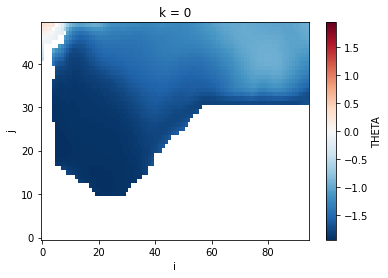

In [13]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [14]:
coords.hFacC

<xarray.DataArray 'hFacC' (k: 50, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(50, 270, 360), dtype=float32, chunksize=(50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction

In [10]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

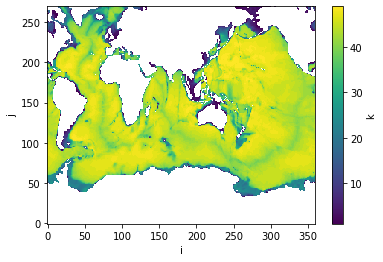

In [11]:
depth_max.plot()

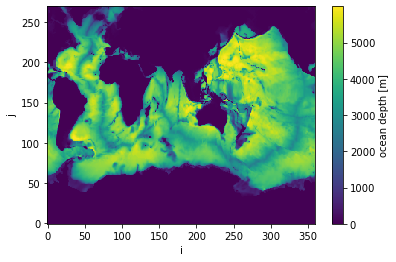

In [46]:
coords.Depth.plot()

In [54]:
coords_wg = coords_before_drop.isel(**lat_range, **lon_range)

In [91]:
coords_wg.Depth.to_netcdf('depth_wg.nc', mode='w')

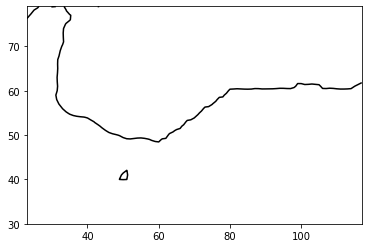

In [55]:
plt.contour(coords_wg.i, coords_wg.j, coords_wg.Depth, levels=[1000], colors='k')

In [31]:
bottom_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4'))

In [32]:
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range).load()

In [33]:
bottom_temp_wg

<xarray.DataArray 'THETA' (time: 288, j: 50, i: 95)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.46867728,  1.7959569 ,  1.7288482 , ..., -0.63816595,
         -0.6382606 , -0.6382265 ],
        [-0.05218363,  0.13044833,  1.811099  , ..., -0.6396008 ,
         -0.63945144, -0.6392597 ],
        [-0.05472618, -0.10532754,  0.062052  , ..., -0.64123577,
         -0.64078325, -0.64044195]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.6944544 ,  1.8897102 ,  1.8287387 , ..., -0.57349426,
         -0.57428366, -0.5748251 ],
        [ 0.30844426,  0.3906638 ,  1.8923483 , ..., -0.5740669 ,
         -0.57464576, -0.5751689 ],
        [ 0.29951465,  0.26471093,  0.35378653, ..., -0.5745686 ,
         -0.5749115 , -0.5754153 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.6921614 ,  1.8880028 ,  1.8286233 , ..., -0.5732399 ,
         -0.5739944 , -0.5745553 ],
        [ 0.30468023,  0.38868093,  1.8914307 , ..., -0.57375324,
         -0.57429785, -0.57485354],
        [ 0.29538646,  0.26396686,  0.35274544, ..., -0.57418454,
         -0.5744802 , -0.57504123]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      Potential Temperature
    standard_name:  THETA
    units:          degC

In [34]:
bottom_temp_wg_mean = bottom_temp_wg.mean(dim='time').load()

In [35]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [36]:
bottom_temp_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_temp_wg_mean

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117

In [37]:
lon = coords_before_drop.XC.isel(**lon_range, **lat_range)
lat = coords_before_drop.YC.isel(**lat_range, **lon_range)

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


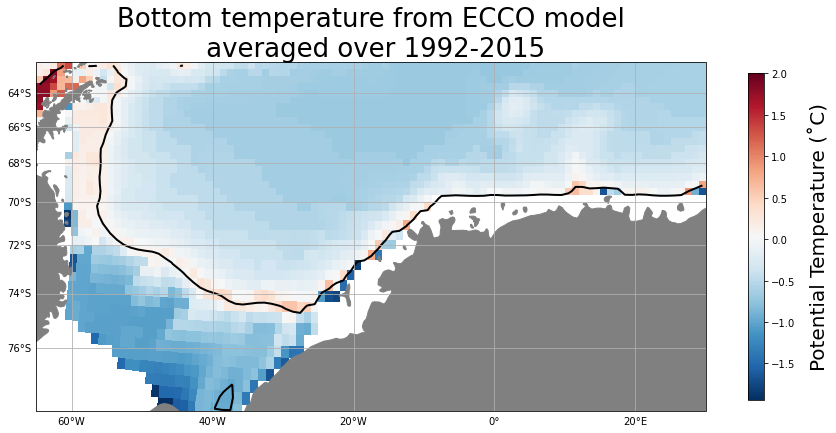

In [85]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords_wg.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_temp_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from ECCO model\n averaged over 1992-2015', fontsize=26)
plt.savefig('bot-temp-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [61]:
bottom_std_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_temp_wg = bottom_std_temp.isel(**lat_range, **lon_range)

In [62]:
bottom_std_temp_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_std_temp_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)
bottom_std_temp_wg

<xarray.DataArray 'THETA' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 95), chunktype=numpy.ndarray>
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>

In [63]:
bottom_std_temp_wg.load()

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07491323, 0.03105013, 0.08613247, ..., 0.02001635, 0.01984921,
        0.01967735],
       [0.10633206, 0.08333268, 0.0289332 , ..., 0.02005466, 0.01991507,
        0.01977147],
       [0.10318091, 0.11221348, 0.09422934, ..., 0.02019693, 0.02006324,
        0.0199395 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

In [38]:
bottom_std_temp_wg.to_netcdf('bottom_std_temp_ecco.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


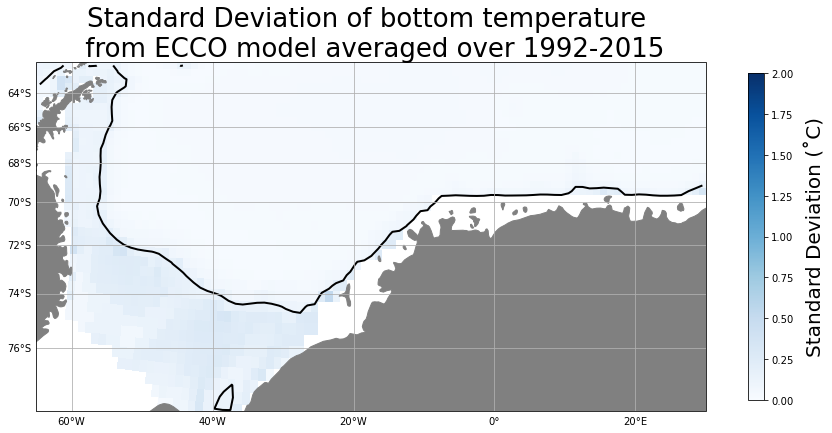

In [84]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords_wg.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_std_temp_wg.where(surface_mask), transform=ccrs.PlateCarree(), 
                   cmap='Blues', vmin=0, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from ECCO model averaged over 1992-2015', fontsize=26)
plt.savefig('std-bot-temp-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)

## Bottom Salinity

In [67]:
bottom_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4'))

In [68]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range).load()

In [69]:
bottom_slt_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_slt_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)

In [70]:
bottom_slt_wg.load()

<xarray.DataArray 'SALT' (time: 288, j: 50, i: 95)>
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.708115, 34.682255, 34.660656, ..., 34.660717, 34.6605  ,
         34.660297],
        [34.701786, 34.704594, 34.6808  , ..., 34.66061 , 34.660397,
         34.6602  ],
        [34.701675, 34.700718, 34.703335, ..., 34.660534, 34.66032 ,
         34.66012 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
...
        [34.716976, 34.68437 , 34.66841 , ..., 34.67846 , 34.67804 ,
         34.677597],
        [34.70827 , 34.710537, 34.675945, ..., 34.678413, 34.677963,
         34.677498],
        [34.70809 , 34.706623, 34.70929 , ..., 34.6784  , 34.67792 ,
         34.67744 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716938, 34.686474, 34.671482, ..., 34.67844 , 34.678024,
         34.677578],
        [34.7082  , 34.710506, 34.67907 , ..., 34.67842 , 34.677975,
         34.67752 ],
        [34.707985, 34.70662 , 34.709286, ..., 34.678436, 34.67797 ,
         34.6775  ]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [48]:
bottom_slt_wg.to_netcdf('bottom_slt_wg.nc')

In [71]:
bottom_slt_wg_mean = bottom_slt_wg.mean(dim='time')

In [72]:
bottom_slt_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_slt_wg_mean.load()

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.712536, 34.676   , 34.642563, ..., 34.6691  , 34.668694,
        34.66834 ],
       [34.702305, 34.706024, 34.67171 , ..., 34.669205, 34.668774,
        34.66839 ],
       [34.702038, 34.700333, 34.704147, ..., 34.66935 , 34.668922,
        34.668484]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


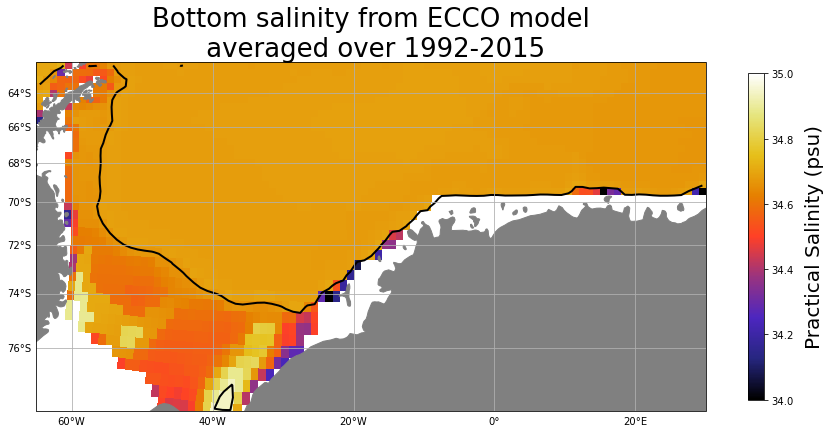

In [83]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords_wg.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_slt_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='CMRmap', vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=26)
plt.savefig('bot-salt-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [75]:
bottom_std_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_slt_wg = bottom_std_slt.isel(**lat_range, **lon_range)

In [76]:
bottom_std_slt_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_std_slt_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)
bottom_std_slt_wg

<xarray.DataArray 'SALT' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 95), chunktype=numpy.ndarray>
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>

In [77]:
bottom_std_slt_wg.load()

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00273975, 0.00564287, 0.01474723, ..., 0.00557772, 0.00552944,
        0.00547744],
       [0.00240092, 0.0022759 , 0.00506051, ..., 0.00562872, 0.0055671 ,
        0.00550446],
       [0.00243282, 0.00255845, 0.00248424, ..., 0.00568517, 0.00561054,
        0.00553797]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

In [55]:
bottom_std_slt_wg.to_netcdf('bottom_std_slt_ecco.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


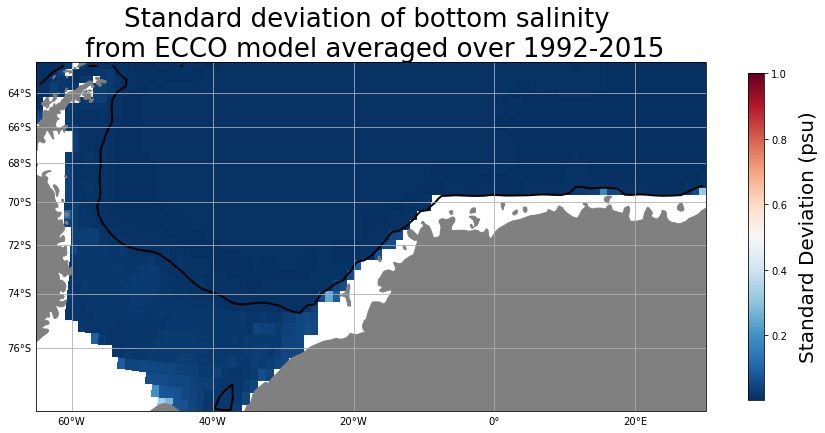

In [86]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, coords_wg.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon, lat, bottom_std_slt_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (psu)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom salinity \n from ECCO model averaged over 1992-2015', fontsize=26)
plt.savefig('std-bot-salt-ecco-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)

## <span style='color:Red'> Bottom Salinity Z-score (end)